<a href="https://colab.research.google.com/github/gabrielfea/previsaoacoes/blob/main/analise_modelo_pred_acoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pmdarima
!pip install tensorflow
!pip install keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.8 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import metrics
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn import preprocessing

from pmdarima import auto_arima

import yfinance as yf
yf.pdr_override()

from pandas_datareader import data as pdr

import datetime
from datetime import date
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import plotly.figure_factory as ff
import plotly.offline as py
from plotly.subplots import make_subplots

from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten,TimeDistributed,RepeatVector
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Dropout

tf.random.set_seed(123)
np.random.seed(123)
import random
random.seed(123)

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


# Análise de Ação B3

In [5]:
def get(tickers,startdate,enddate):
   def data(ticker):
       return(pdr.get_data_yahoo(ticker, start=startdate,end=enddate))
   datas = map(data,tickers)
   all_data = pd.concat(datas, keys=tickers, names=['Ticker', 'Date'])
   return all_data

In [6]:
def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [7]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [8]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [9]:
def preve_acao(asset,imprime_grafico=False):
  #asset = "ITUB4.SA"
  tickers = [asset]
  startdate = date(2000,1,1)
  enddate = date.today()

  data = get(tickers,startdate,enddate)


  #data.loc[asset].tail()

  df = data.loc[asset,["Close","High","Low"]]
  df_cycle,df_trend = hpfilter(df["Close"], lamb=1600)
  #df["Close"].plot(figsize=(15,6)).autoscale(axis='x',tight=True)
  #df_trend.plot(figsize=(15,6)).autoscale(axis='x',tight=True)
  df["Trend"] = df_trend
  df_close = df["Close"]
  tamanho = len(df["Close"])

  h = 90
  predition_X = df.tail(h)
  uni_data = df.drop(df.tail(h).index)

  x_scaler = preprocessing.StandardScaler()
  y_scaler = preprocessing.StandardScaler()
  dataX = x_scaler.fit_transform(df)
  dataY = y_scaler.fit_transform(df[['Trend']]) #y_scaler.fit_transform(np.array(df).reshape(-1, 1))

  hist_window = 60
  horizon = h

  index_prev = data.loc[asset].index[-h:]
  index_prev

  from pandas.tseries.holiday import USFederalHolidayCalendar
  from pandas.tseries.offsets import CustomBusinessDay
  us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
  index_prev_oficial = pd.period_range(start=index_prev[-1], periods=h+1, freq=us_bd)[1:]


  TRAIN_SPLIT = int((tamanho-h)*0.80)
  x_train_multi, y_train_multi = custom_ts_multi_data_prep(
      dataX, dataY, 0, TRAIN_SPLIT, hist_window, horizon)
  x_val_multi, y_val_multi= custom_ts_multi_data_prep(
      dataX, dataY, TRAIN_SPLIT, None, hist_window, horizon)

  BATCH_SIZE = 60
  BUFFER_SIZE = 60

  train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
  train_data_multi = train_data_multi.cache().batch(BATCH_SIZE).repeat()

  val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
  val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

  LSTM_model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(60, input_shape=x_train_multi.shape[-2:],return_sequences=True),
      tf.keras.layers.LSTM(units=60,return_sequences=True),
      tf.keras.layers.LSTM(units=60),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(units=horizon),
  ])
  LSTM_model.compile(optimizer='adam', loss='mse')

  model_path = f'drive/MyDrive/modelos_ia_prev_acoes/{asset[:5]}.h5'

  try:
    Trained_model = tf.keras.models.load_model(model_path)
    #Trained_model.summary()
  except:
    print("Modelo não treinado ainda!")
    EVALUATION_INTERVAL = 100
    EPOCHS = 150
    history = LSTM_model.fit(train_data_multi, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_data_multi, validation_steps=50,verbose =1,callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])
    Trained_model = tf.keras.models.load_model(model_path)
    #Trained_model.summary()

  data_val = x_scaler.fit_transform(uni_data.tail(hist_window))
  val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
  Predicted_results = Trained_model.predict(val_rescaled)
  #Predicted_results

  df2 = predition_X
  df2_cycle,df2_trend = hpfilter(df2["Close"], lamb=1600)
  df2["Trend"] = df2_trend
  data_pred = x_scaler.fit_transform(df2.tail(hist_window))
  pred_rescaled = data_pred.reshape(1, data_pred.shape[0], data_pred.shape[1])
  Predicted_results_oficial = Trained_model.predict(pred_rescaled)
  Predicted_results_oficial_Inv_trans = y_scaler.inverse_transform(Predicted_results_oficial.reshape(-1,1))
  Predicted_results_oficial_Inv_trans = pd.DataFrame(Predicted_results_oficial_Inv_trans, columns=['Trend'], index=index_prev_oficial)
  Predicted_results_oficial_Inv_trans_cycle,Predicted_results_oficial_Inv_trans_trend = hpfilter(Predicted_results_oficial_Inv_trans, lamb=1600)
  ajuste2 = Predicted_results_oficial_Inv_trans_trend[0]-df_close.tail(h+1)[-1]
  Predicted_results_oficial_Inv_trans = Predicted_results_oficial_Inv_trans-ajuste2
  Predicted_results_oficial_Inv_trans_trend = Predicted_results_oficial_Inv_trans_trend-ajuste2

  Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results.reshape(-1,1))
  Predicted_results_Inv_trans = pd.DataFrame(Predicted_results_Inv_trans, columns=['Trend'], index=index_prev)
  Predicted_results_Inv_trans_cycle,Predicted_results_Inv_trans_trend = hpfilter(Predicted_results_Inv_trans, lamb=1600)
  ajuste = Predicted_results_Inv_trans_trend[0]-df_close.tail(h+1)[0]
  Predicted_results_Inv_trans_trend = Predicted_results_Inv_trans_trend-ajuste
  Predicted_results_Inv_trans = Predicted_results_Inv_trans-ajuste

  validate = pd.DataFrame(df_close.tail(h), columns=['Close'], index=index_prev)
  alta_estimada = round((max(Predicted_results_oficial_Inv_trans_trend)/Predicted_results_oficial_Inv_trans_trend[0]-1)*100,2)
  baixa_estimada = round((min(Predicted_results_oficial_Inv_trans_trend)/Predicted_results_oficial_Inv_trans_trend[0]-1)*100,2)
  MAPE = mean_absolute_percentage_error(validate,Predicted_results_Inv_trans_trend)
  r2 = metrics.r2_score(validate,Predicted_results_Inv_trans_trend)

  if imprime_grafico == True:

    print()
    print("_"*75)
    print(asset)
    timeseries_evaluation_metrics_func(validate,Predicted_results_Inv_trans_trend)
    print(f'Alta estimada: {alta_estimada} %')

    plt.plot(df_close.tail(h+100))
    #plt.plot( Predicted_results_Inv_trans)
    #plt.plot( Predicted_results_oficial_Inv_trans)
    plt.plot(Predicted_results_Inv_trans_trend)
    plt.plot(Predicted_results_oficial_Inv_trans_trend)
    plt
    plt.title("Actual vs Predicted")
    plt.ylabel(f'{asset}')
    plt.legend(('Actual','validation_trend','predicted_trend'))
    plt.show()


  return [alta_estimada,baixa_estimada,MAPE,r2]

In [10]:
assets_df = pd.read_csv('drive/MyDrive/assets.csv', delimiter=";")

In [11]:
analise_df = pd.DataFrame(columns=['Asset','Alta_estimada (%)','Baixa_estimada (%)', 'MAPE','r2'])
for i in assets_df.iloc[300:]["codigo"]:
  if i not in ["ALOS3","CACR11","RZAT11","BROF11","GARE11","RBRX11","TRBL11","SPXS11","TVRI11","VCRI11","A1MT34","INEP4","S2TA34"]:
    print()
    print(i)
    result = preve_acao(i+".SA")
    analise_df = analise_df.append({'Asset':i,'Alta_estimada (%)':result[0],'Baixa_estimada (%)':result[1],'MAPE':result[2],'r2':result[3]},ignore_index=True)


IFCM3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 84ms/step

ITLC34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 41ms/step

INTB3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 66ms/step

MYPK3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 47ms/step

RANI3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

IRBR3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 26ms/step

ITSA3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 43ms/step

ITSA4


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

ITUB3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

ITUB4


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 42ms/step

JALL3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

JBSS3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

JDCO34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 43ms/step

JHSF3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

JNJB34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

JPMC34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 41ms/step

JSLG3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

KEPL3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

K2CG34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 53ms/step

KLBN11


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

KHCB34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

LAVV3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 41ms/step

LILY34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

L1YG34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

RENT3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

LOGG3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 25ms/step

LOGN3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

AMAR3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 44ms/step

LREN3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

LPSB3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

L1MN34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 48ms/step

LUPA3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

LWSA3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

MDIA3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

MGLU3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

POMO3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 26ms/step

POMO4


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 41ms/step

MRFG3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

MSCD34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

MATD3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

MCDC34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 25ms/step

M2PW34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

CASH3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 49ms/step

MELK3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 25ms/step

MELI34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

BMEB3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 40ms/step

BMEB4


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

MRCK34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

M1TA34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 46ms/step

LEVE3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

MUTC34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

MSFT34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

MILS3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

BEEF3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

MTRE3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 39ms/step

MBLY3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

M1RN34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

M1NS34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 50ms/step

MSBR34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

MOSC34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

MDNE3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 43ms/step

MOVI3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

MRVE3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 33ms/step

MLAS3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 45ms/step

MULT3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

N1DA34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

NEOE3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 64ms/step

NGRD3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

NFLX34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 26ms/step

E1DU34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 43ms/step

N1EM34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

NEXT34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

NIKE34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 44ms/step

N1VO34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

NVDC34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

OXYP34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 42ms/step

OPCT3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

ODPV3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

ONCO3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 39ms/step

ORCL34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

ORVR3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

OFSA3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 40ms/step

PCAR3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

PDTC3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

PAGS34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 40ms/step

PGMN3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

P2LT34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

P2AN34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 38ms/step

PYPL34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 26ms/step

P1DD34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

PEPB34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 47ms/step

PETR3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

PETR4


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 26ms/step

RECV3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 42ms/step

PRIO3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

PTNT4


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

PETZ3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 43ms/step

PFIZ34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

PGCO34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 25ms/step

PINE4


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 39ms/step

PLPL3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

PSSA3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

PTBL3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 44ms/step

POSI3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

PRNR3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 26ms/step

PFRM3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 55ms/step

P1LD34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

QCOM34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

QUAL3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 45ms/step

LJQQ3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

RADL3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

RAIZ4


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 45ms/step

RAPT3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

RAPT4


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 26ms/step

R1IN34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 49ms/step

RCSL3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

RDOR3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 26ms/step

RIOT34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 42ms/step

RDNI3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 26ms/step

R2BL34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

ROMI3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 43ms/step

RAIL3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

SBSP3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 26ms/step

SSFO34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 42ms/step

SAPR11


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

BCSA34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

SANB11


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 44ms/step

STBP3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

SCAR3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

SMTO3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

SCHW34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 36ms/step

S2EA34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

SEER3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

SRNA3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

S2HO34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

S1BS34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

CSNA3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

SIMN34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 26ms/step

SIMH3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 32ms/step

S1LG34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

SLCE3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

SMFT3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

SNEC34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 26ms/step

S1PO34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

SGPS3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

SBUB34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 35ms/step

S2UI34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

SUZB3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

SYNE3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

TAEE11


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 41ms/step

TSMC34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

T1TW34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

T1AL34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

TASA3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 32ms/step

TASA4


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

TRAD3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 45ms/step

TECN3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

TCSA3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

TGMA3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 55ms/step

T2DH34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

VIVT3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

TLNC34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 46ms/step

TEND3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 37ms/step

LAND3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

TSLA34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 47ms/step

TEXA34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

TIMS3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

SHOW3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 37ms/step

TOTS3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

TMCO34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

TFCO4


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 54ms/step

T2TD34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

TRPL3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 44ms/step

TRPL4


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 39ms/step

RIGG34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

TRIS3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 26ms/step

TPIS3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

TUPY3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

U1BE34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

UGPA3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

UCAS3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

FIQE3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

ULEV34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

UNIP6


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

UNHH34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

U2ST34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 26ms/step

U2PS34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

USIM3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

USIM5


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

VALE3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

VLID3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 42ms/step

VAMO3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

VERZ34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 38ms/step

VSTE3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 45ms/step

VBBR3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

VISA34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

VITT3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 51ms/step

VIVA3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

VVEO3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

VIVR3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 44ms/step

VULC3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

WALM34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

DISB34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 39ms/step

LVTC3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

WEGE3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

WFCO34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 39ms/step

WEST3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

PORT3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

WIZC3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 43ms/step

YDUQ3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

ZAMP3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

Z1TS34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 43ms/step

Z1OM34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step


#PREVISÃO PARA 3 MESES (60 PREGÕES)


### Maior alta estimada e maior baixa estimada em relação ao presente

In [12]:
sugestoes_df = analise_df[(analise_df['r2']>0) & (analise_df['MAPE']<13) & (analise_df['Alta_estimada (%)']>5)].sort_values(by=['Alta_estimada (%)'],ascending=False)

In [13]:
sugestoes_df = sugestoes_df.join(assets_df.set_index('codigo'),on='Asset').reset_index(drop=True)


___________________________________________________________________________
___________________________________________________________________________
MAGAZ LUIZA


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

___________________________________________________________________________
MGLU3.SA
Evaluation metric results:-
MSE is : 0.056096885775804683
MAE is : 0.17016569369516368
RMSE is : 0.23684781142287273
MAPE is : 11.815623822366208
R2 is : 0.11109003096658487

Alta estimada: 72.12 %


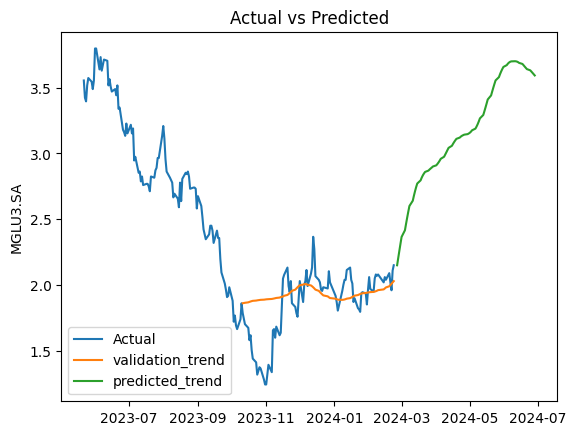

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
SANTANDER


1/1 [==============================] - 0s 42ms/step

___________________________________________________________________________
BCSA34.SA
Evaluation metric results:-
MSE is : 0.5220774727015323
MAE is : 0.6343634241347311
RMSE is : 0.7225492873856649
MAPE is : 4.059409564612868
R2 is : 0.16959925831914835

Alta estimada: 12.52 %


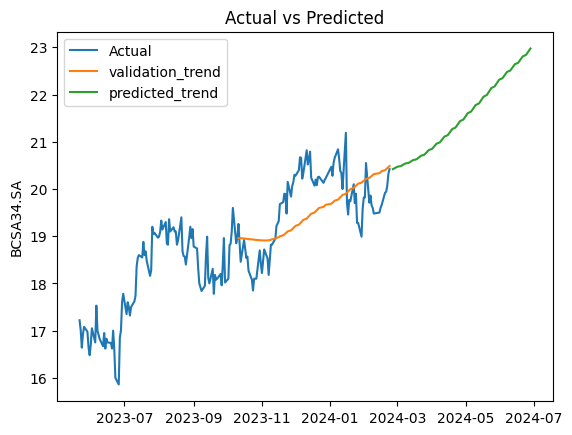

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
PALOALTO NET


1/1 [==============================] - 0s 26ms/step

___________________________________________________________________________
P2AN34.SA
Evaluation metric results:-
MSE is : 8.593768023109597
MAE is : 2.1873050848762485
RMSE is : 2.931512923919933
MAPE is : 11.848745275828586
R2 is : 0.18816673801195116

Alta estimada: 12.18 %


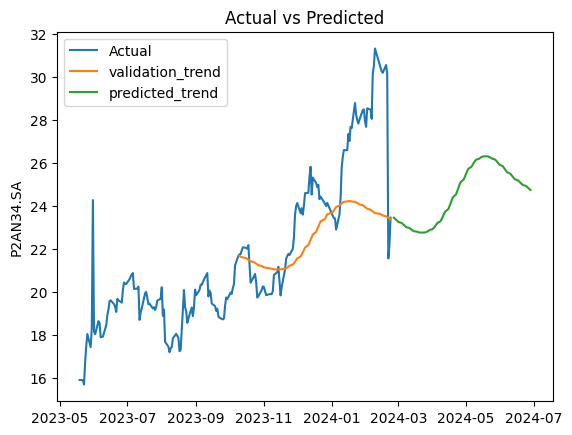

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
KRAFT HEINZ


1/1 [==============================] - 0s 31ms/step

___________________________________________________________________________
KHCB34.SA
Evaluation metric results:-
MSE is : 2.474414712355601
MAE is : 1.3116886449531115
RMSE is : 1.5730272446323366
MAPE is : 5.716172344927454
R2 is : 0.5844429334667927

Alta estimada: 11.07 %


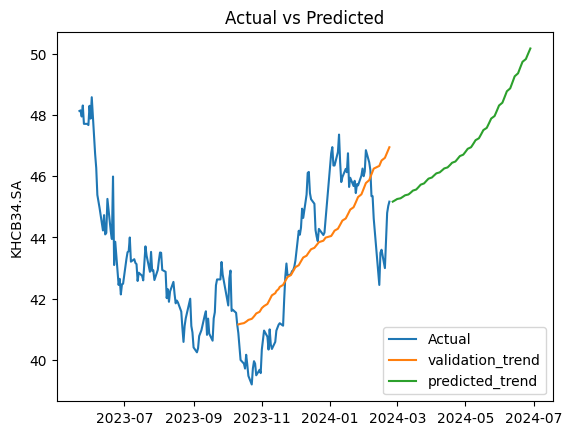

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
ZOETIS INC


1/1 [==============================] - 0s 29ms/step

___________________________________________________________________________
Z1TS34.SA
Evaluation metric results:-
MSE is : 8.701568853915514
MAE is : 2.282422434634468
RMSE is : 2.9498421744078978
MAPE is : 6.140201859035638
R2 is : 0.3450272162660387

Alta estimada: 10.42 %


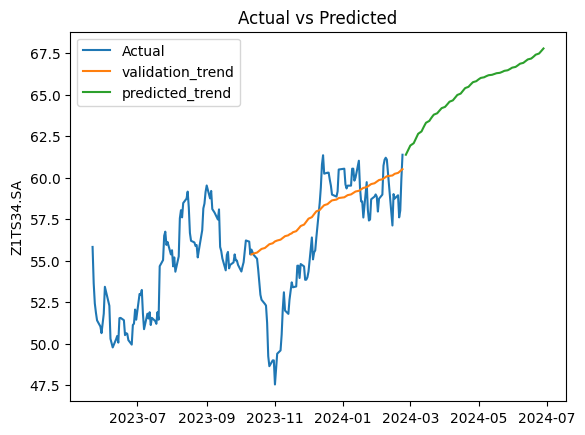

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
VIVARA S.A.


1/1 [==============================] - 0s 26ms/step

___________________________________________________________________________
VIVA3.SA
Evaluation metric results:-
MSE is : 5.116158169236939
MAE is : 1.930079430878436
RMSE is : 2.2618926078036816
MAPE is : 10.398429330060301
R2 is : 0.539913849561666

Alta estimada: 10.25 %


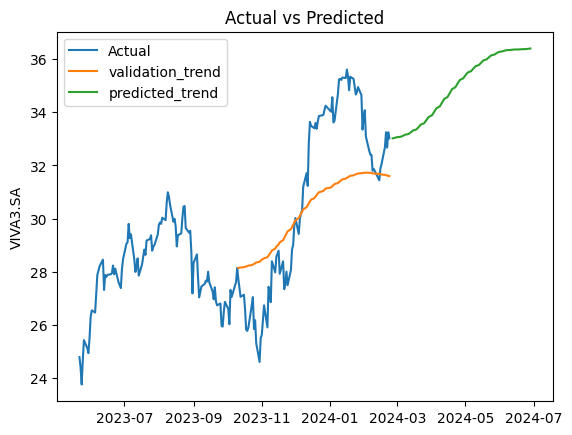

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
LLOYDS BANKI


1/1 [==============================] - 0s 28ms/step

___________________________________________________________________________
L1YG34.SA
Evaluation metric results:-
MSE is : 0.39089151962015684
MAE is : 0.5406195176984919
RMSE is : 0.6252131793397807
MAPE is : 5.21484932395662
R2 is : 0.06519972969555077

Alta estimada: 9.6 %


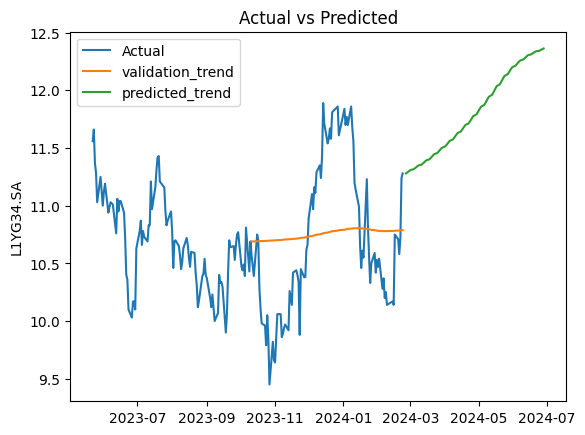

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
OUROFINO S/A


1/1 [==============================] - 0s 29ms/step

___________________________________________________________________________
OFSA3.SA
Evaluation metric results:-
MSE is : 3.0359844132425127
MAE is : 1.3316654723702892
RMSE is : 1.7424076484113908
MAPE is : 7.417855049176729
R2 is : 0.21579638096711007

Alta estimada: 7.09 %


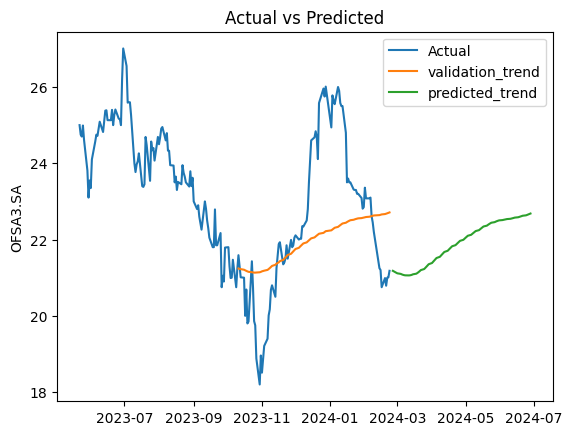

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
MONSTER BEVE


1/1 [==============================] - 0s 29ms/step

___________________________________________________________________________
M1NS34.SA
Evaluation metric results:-
MSE is : 1.4826191007915153
MAE is : 1.015667613695136
RMSE is : 1.217628474039399
MAPE is : 5.140990343983496
R2 is : 0.1164500500293576

Alta estimada: 6.85 %


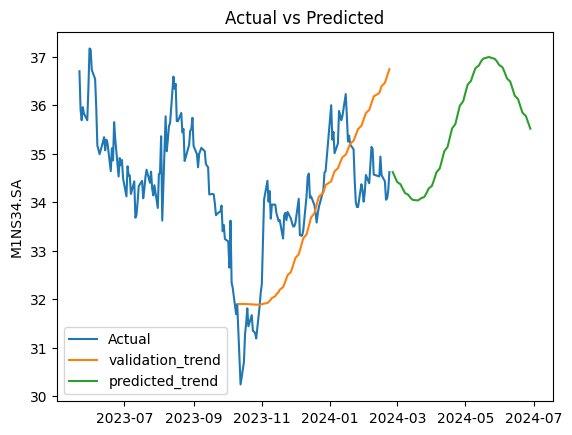


___________________________________________________________________________
___________________________________________________________________________
SAO CARLOS


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

___________________________________________________________________________
SCAR3.SA
Evaluation metric results:-
MSE is : 2.5041269976122495
MAE is : 1.3463702665280495
RMSE is : 1.582443363160985
MAPE is : 7.174778204040876
R2 is : 0.33989142593588095

Alta estimada: 6.3 %


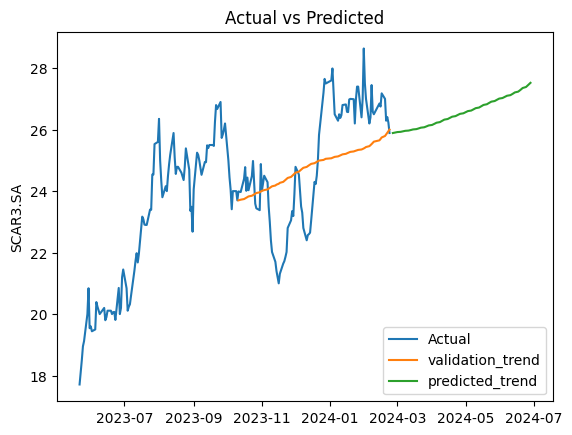


___________________________________________________________________________
___________________________________________________________________________
LILLY


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 27ms/step

___________________________________________________________________________
LILY34.SA
Evaluation metric results:-
MSE is : 84.19221188830392
MAE is : 6.579170768094432
RMSE is : 9.17563141632792
MAPE is : 6.700047163570899
R2 is : 0.17057132884164972

Alta estimada: 5.56 %


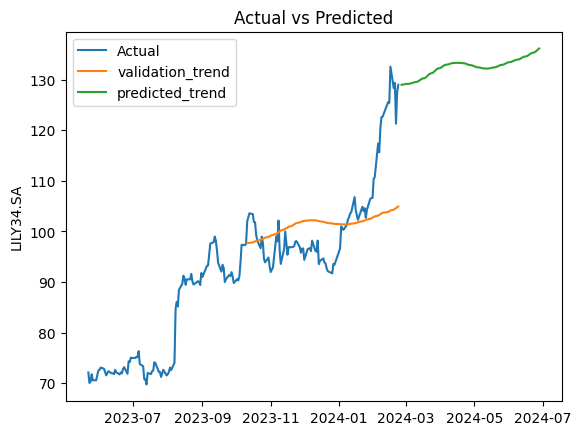

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
REALTY INCOM


1/1 [==============================] - 0s 44ms/step

___________________________________________________________________________
R1IN34.SA
Evaluation metric results:-
MSE is : 28.305874725574633
MAE is : 4.254614856520969
RMSE is : 5.3203265619296936
MAPE is : 4.4424012127521175
R2 is : 0.39676996975846024

Alta estimada: 5.48 %


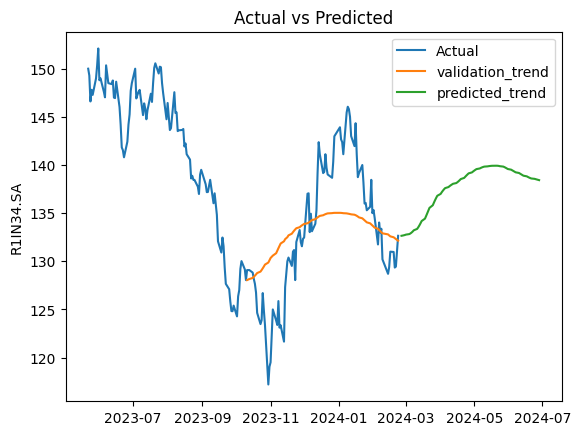

In [14]:
for i,t in zip(sugestoes_df["Asset"],sugestoes_df["empresa"]):
  print()
  print("_"*75)
  print("_"*75)
  print(t)
  preve_acao(i+".SA",True)

In [17]:
tickers = [ticker+".SA" for ticker in sugestoes_df["Asset"]]
startdate =  date(2023,1,1)
enddate = date.today()
data = get(tickers,startdate,enddate)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [24]:
analise_sugestoes_df = pd.DataFrame(data["Close"])

In [28]:
analise_sugestoes_df.reset_index(inplace=True)

In [32]:
analise_sugestoes_df.set_index("Date",inplace=True)

In [41]:
coor = analise_sugestoes_df.pivot_table(index="Date",columns="Ticker",values="Close").corr()

In [42]:
coor.style.background_gradient(cmap='coolwarm')

Ticker,BCSA34.SA,KHCB34.SA,L1YG34.SA,LILY34.SA,M1NS34.SA,MGLU3.SA,OFSA3.SA,P2AN34.SA,R1IN34.SA,SCAR3.SA,VIVA3.SA,Z1TS34.SA
Ticker,,,,,,,,,,,,
BCSA34.SA,1.000000,-0.205065,0.030913,0.434773,-0.174826,-0.489592,-0.164370,0.551772,-0.263690,0.338396,0.475297,0.616143
KHCB34.SA,-0.205065,1.000000,0.846232,-0.657948,-0.006947,0.618944,0.677784,-0.554782,0.872351,-0.757328,-0.592383,-0.157626
L1YG34.SA,0.030913,0.846232,1.000000,-0.699951,-0.188214,0.614210,0.724227,-0.569994,0.880024,-0.757364,-0.540743,-0.097200
LILY34.SA,0.434773,-0.657948,-0.699951,1.000000,0.105281,-0.805597,-0.703102,0.852196,-0.837567,0.879062,0.791232,0.546082
M1NS34.SA,-0.174826,-0.006947,-0.188214,0.105281,1.000000,0.231314,0.187814,0.140272,-0.023213,0.186313,0.278142,0.331180
MGLU3.SA,-0.489592,0.618944,0.614210,-0.805597,0.231314,1.000000,0.776486,-0.675442,0.799820,-0.746057,-0.571546,-0.294537
OFSA3.SA,-0.164370,0.677784,0.724227,-0.703102,0.187814,0.776486,1.000000,-0.471548,0.828542,-0.594946,-0.301605,-0.031424
P2AN34.SA,0.551772,-0.554782,-0.569994,0.852196,0.140272,-0.675442,-0.471548,1.000000,-0.705000,0.782110,0.855454,0.577338
R1IN34.SA,-0.263690,0.872351,0.880024,-0.837567,-0.023213,0.799820,0.828542,-0.705000,1.000000,-0.826029,-0.625358,-0.254078


In [43]:
sugestoes_df

,Asset,Alta_estimada (%),Baixa_estimada (%),MAPE,r2,empresa
0,MGLU3,72.12,0.00,11.815624,0.111090,MAGAZ LUIZA
1,BCSA34,12.52,0.00,4.059410,0.169599,SANTANDER
2,P2AN34,12.18,-2.97,11.848745,0.188167,PALOALTO NET
3,KHCB34,11.07,0.00,5.716172,0.584443,KRAFT HEINZ
4,Z1TS34,10.42,0.00,6.140202,0.345027,ZOETIS INC
5,VIVA3,10.25,0.00,10.398429,0.539914,VIVARA S.A.
6,L1YG34,9.60,0.00,5.214849,0.065200,LLOYDS BANKI
7,OFSA3,7.09,-0.57,7.417855,0.215796,OUROFINO S/A
8,M1NS34,6.85,-1.68,5.140990,0.116450,MONSTER BEVE
9,SCAR3,6.30,0.00,7.174778,0.339891,SAO CARLOS
